In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
#tf.enable_eager_execution()

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np

import tensorflow.keras

import os
from glob import glob

import timeit

from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import clear_output
import datetime

import pandas as pd

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
from Model import make_KaI

In [5]:
img_height = 100
img_width = 100
nclasses=2
filters=16
one_hot=2
deep = True
zero_pad = 28

KaI = make_KaI(img_height, img_width, nclasses, filters, one_hot, deep, zero_pad, channels = 1)

Using TensorFlow backend.


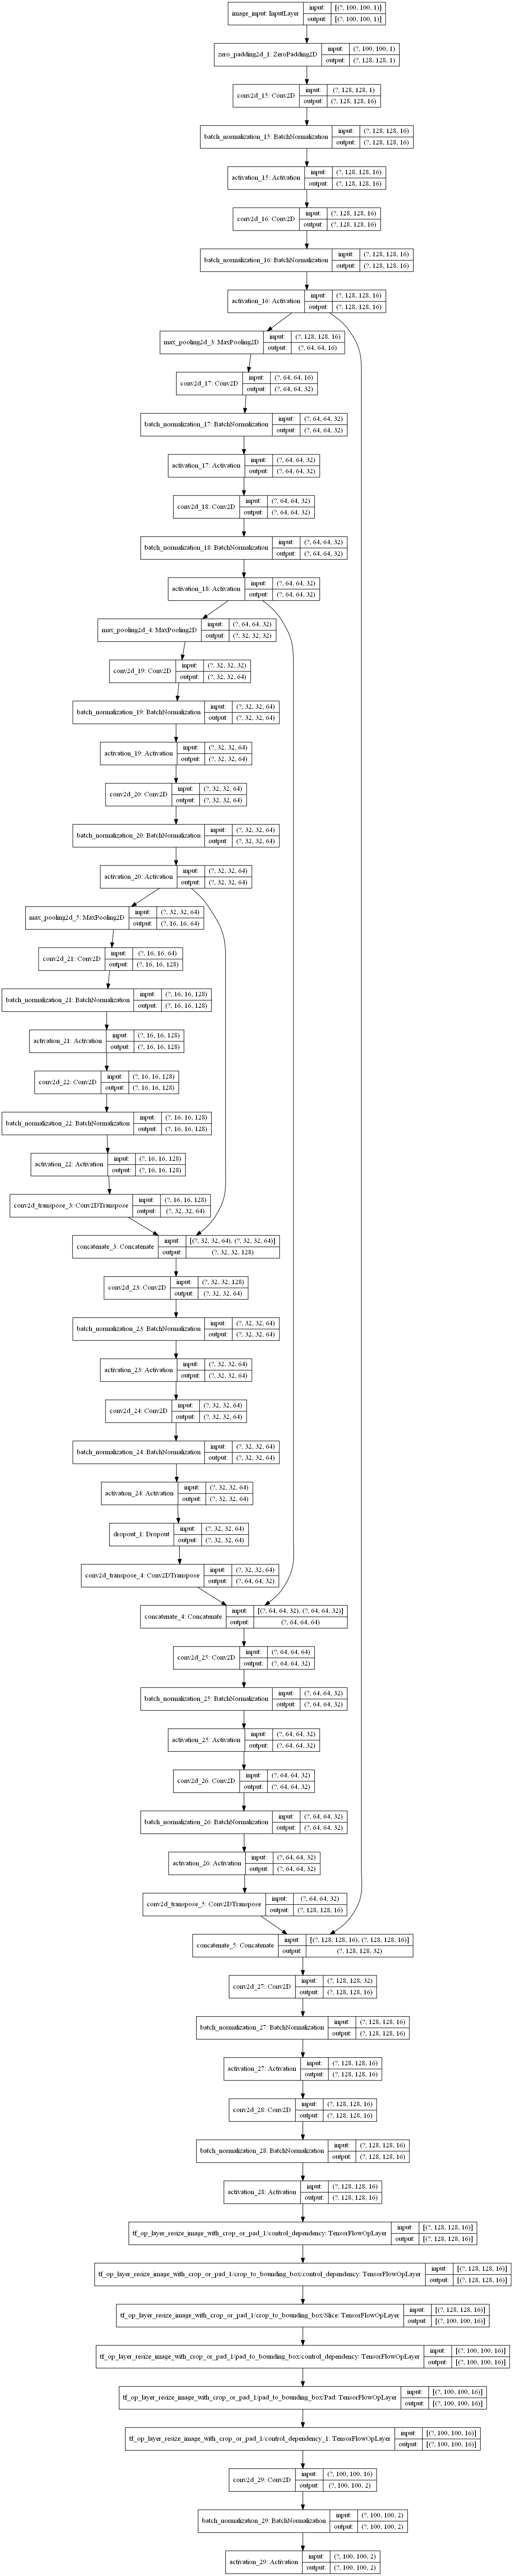

In [6]:
import pydotplus
import keras.utils
keras.utils.vis_utils.pydot = pydotplus
tf.keras.utils.plot_model(KaI, to_file="D:/Masterarbeit/Data/model_full_KaI_slovenia.png", show_shapes=True)

In [ ]:
from Data import image_generator

In [ ]:
files_mask_train = glob("D:\\Masterarbeit\\Data\\high_res\\slovenia_1m\\tf_data\\train\\WOKAM\\subfolder\\*")
files_img_train = glob("D:\\Masterarbeit\\Data\\high_res\\slovenia_1m\\tf_data\\train\\LIDAR\\subfolder\\*")

files_mask_test = glob("D:\\Masterarbeit\\Data\\high_res\\slovenia_1m\\tf_data\\test\\WOKAM\\subfolder\\*")
files_img_test = glob("D:\\Masterarbeit\\Data\\high_res\\slovenia_1m\\tf_data\\test\\LIDAR\\subfolder\\*")

In [ ]:
train_generator = image_generator(files_img_train, files_mask_train, batch_size = 64, intensify = False, random = True, categorical = True)
test_generator = image_generator(files_img_test, files_mask_test, batch_size = 64, intensify = False, random = False, categorical = True)

In [ ]:
for i in range(0,12):
    
    x, y = next(test_generator)
    image = x[i]
    mask = y[i].reshape(128,128)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    ax1.imshow(image)
    ax2.imshow(mask, cmap = "Greys")
    
    plt.show()

In [ ]:
adam = tf.keras.optimizers.Adam(lr=0.001)

In [ ]:
def dice_coe(output, target, loss_type='jaccard', axis=(1, 2, 3), smooth=1e-5):
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # old axis=[0,1,2,3]
    # dice = 2 * (inse) / (l + r)
    # epsilon = 1e-5
    # dice = tf.clip_by_value(dice, 0, 1.0-epsilon) # if all empty, dice = 1
    # new haodong
    dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice

In [ ]:
KaI.compile(optimizer= adam, loss = dice_coe , metrics=['categorical_accuracy'])

In [ ]:
batch_size = 64

In [ ]:
tb_dir = "D:\\Masterarbeit\\Data\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ "_high_res_dice_one_hot"

tb = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, write_graph=True, histogram_freq= 1)
mc = tf.keras.callbacks.ModelCheckpoint(mode='max', filepath='D:/Masterarbeit/Data/weights/top_weights_200511_high_res_dice_one_hot.h5', monitor='categorical_accuracy', save_best_only='True', save_weights_only='True', verbose=1)
callbacks = [tb, mc]

a = datetime.datetime.now()
history = KaI.fit_generator(
train_generator,
steps_per_epoch=len(files_mask_test) // batch_size,
epochs= 100,
validation_data= test_generator,
validation_steps=len(files_mask_test) // batch_size , 
callbacks=callbacks
)
b = datetime.datetime.now()
print(b-a)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'D:/Masterarbeit/Data/weights/history_high_res_dice_one_hot.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)